# Evaluation of _waveome_ with simulated data

## Strategy

Simulate data from known GPs and see recovery coverage with correct model possible. Vary signal-to-noise ratio (i.e. epsilon in latent function) dispersion parameter, sample size (# obs and # units), and number of covariates. Want to align with metabolomics data so will generate from non-Gaussian likelihood. Allow for both linear and nonlinear relationships to be present.

## Comparators

- _waveome_ search
- _waveome_ penalization
- Linear mixed effect model (Mixed LM)
- Generalized linear model (GLM)
- LASSO
- Generalized Additive Model (GAM)
- Automatic Relevance Determination (ARD) GP
- ARD GP with negative binomial likelihood

## Metrics

- Correct variable(s) selected percentage (precision, recall/sensitivity, specificity)
- KL-divergence 
- Mean squared error

### Kernels

#### Kernel 1: individual offset + matern32 over time
This kernel represents a biological process that has differening individual levels, but across individuals there is a conserved dynamic process occuring. An example of what this might represent is a metabolite that is tied to specific time-dependent events that are similar across individuals (e.g. holidays or large gatherings might produce these effects).

#### Kernel 2: individual offset + individual * squaredexp over time + periodic over time
This kernel represents a biological process that also has differing individual level offsets, individual-specific time components, and an overall periodic process occuring across all individuals. This might represent a metabolite that has a seasonal effect but also depends on a particular individuals behaviors and habits over time. 

#### Kernel 3: individual offset + linear treatment effect
This kernel represents a linear treatment effect over time, where each individual has a different baseline value. This might represent a particular metabolite value that differs by person, but also is affected by a given treatment over time. 

#### Kernel 4: individual offset + polynomial treatment effect + individual * matern32 over time
This kernel represents a nonlinear treatment effect but it is also confounded by the fact that the feature is also changing naturally over time.

## Setup

Run sim_waveome_hpc_run.py script (or sim_waveome_hpc_script.sh with SLURM)

In [24]:
# Show example of simulation data for paper figure
# Libraries
import gpflow
import numpy as np
import pandas as pd

from waveome.kernels import Categorical

# Objects
## Specify kernels
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern12(variance=1.0, 
                              lengthscales=1.0, 
                              active_dims=[2]) + 
      Categorical(variance=2.0,
                  active_dims=[0]))

# Second kernel is random unit specfic effect + time varying unit specific effect + 
# periodic overall effect
k2 = (gpflow.kernels.Matern12(variance=1.,
                                        lengthscales=0.5, 
                                        active_dims=[2]) * 
     Categorical(active_dims=[0]) + 
     gpflow.kernels.Periodic(
         base_kernel=gpflow.kernels.SquaredExponential(
             variance=2., active_dims=[2]), # variance=2.5
         period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (Categorical(active_dims=[0], variance=0.5) + 
      Categorical(active_dims=[1]) * 
      gpflow.kernels.Linear(variance=0.1, 
                            active_dims=[2]))

# Fourth kernel is random unit effect + nonlinear random treatment effect over time + 
# nonlinear individual effect over time
k4 = (Categorical(active_dims=[1], variance=0.001) * 
      gpflow.kernels.Polynomial(degree=2, 
                                offset=3.,
                                variance=1.,
                                active_dims=[2]) + 
      Categorical(active_dims=[0]) *
      gpflow.kernels.SquaredExponential(variance=2.,
                                        lengthscales=0.5,
                                        active_dims=[2]))


# Kernel dictonary
kern_out = {'y1': {'model': k1},
            'y2': {'model': k2},
            'y3': {'model': k3},
            'y4': {'model': k4}}

# Functions
def sim_data(
    rate=12,
    num_units=50,
    fixed_num=False, 
    include_output=True,
    kern_out=None,
    eps=0,
    alpha=1.,
    random_seed=None,
):
    """ Simulate data for evalulation with known GP process.

    """
    
    # Set random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Assign treatment group to each unit
    #treat_group = np.repeat([0,1], num_units/2)
    prob_treat = np.random.beta(a=1, b=1)
    treat_group = np.random.binomial(n=1, p=prob_treat, size=num_units)

    # Sample number of observations for each unit
    if fixed_num:
        num_obs = np.repeat(rate, num_units)
    else:
        num_obs = np.random.poisson(lam=rate, size=num_units)

    # Sample from uniform distribution for observation times
    x = np.concatenate(
        [np.sort(np.round(np.random.uniform(low=0, high=12, size=i),1)) for i in num_obs],
        axis=0
    )

    # Standardize
    x = (x - x.mean()) / x.std()

    # Put unit ID and observation time together
    df = np.array(
        [np.repeat(np.arange(num_units), num_obs),
        np.repeat(treat_group, num_obs),
        x],
        dtype=gpflow.default_float()
    ).T
    
    df = pd.DataFrame(
        df,
        columns = ['id', 'treat', 'time']
    )

    likelihood_params = {}
        
    if include_output and kern_out is not None:

        for k in kern_out.keys():
        
            # Simulate output
            try:
                f_ = np.random.multivariate_normal(
                    mean=np.zeros_like(df.iloc[:,0]).flatten(),
                    cov=(
                        kern_out[k]['model'](df)
                        +1e-6*np.eye(df.shape[0], dtype=gpflow.default_float())
                    ),
                    size=1
                )[0]
            except:
                return None, None
            
            # Add latent
            df[f"{k}_latent"] = f_
            
            # Add noise
            # df[k] = f_ + np.random.normal(loc=0, scale=eps, size=len(f_))
            f_noise_ = f_ + np.random.normal(loc=0, scale=eps, size=len(f_))

            # Transform latent value
            mu_ = np.exp(f_noise_)

            # # Sample dispersion parameter
            # alpha_ = np.random.exponential(scale=1.)
            alpha_ = alpha

            # Transform params to variance
            sigma2_ = mu_ + alpha_ * mu_**2
            p_ = (mu_ / sigma2_)
            n_ = (mu_**2) / (sigma2_ - mu_)

            # Store parameters from likelihood
            likelihood_params[k] = {
                "p": p_,
                "n": n_,
                "alpha": alpha_
            }

            # Now get observed values
            df[k] = np.random.negative_binomial(
                n=n_.flatten(),
                p=p_.flatten(),
                size=len(f_)
            ).astype(float)

    return df, likelihood_params

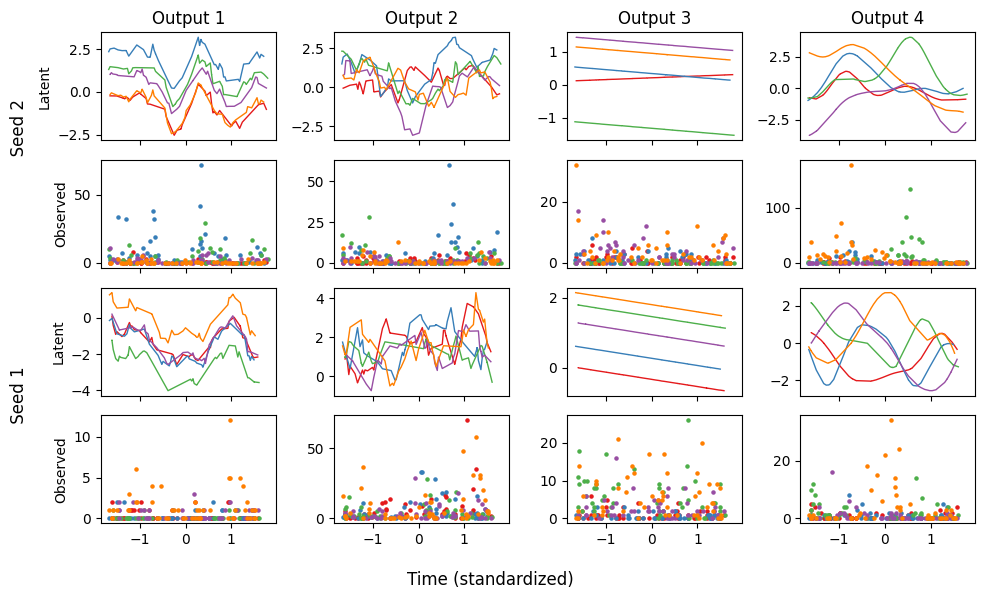

In [25]:
import matplotlib.pyplot as plt

# Plot output
figs, axs = plt.subplots(4, 4, sharex=True, figsize=(10, 6))

# Loop through seed values
for seed_val in [0, 1]:
    sim_df, sim_dict = sim_data(
        kern_out=kern_out,
        random_seed=seed_val,
        num_units=5,
        rate=50,
        eps=0,
        alpha=1,
        fixed_num=True
    )

    # Loop through outputs and individual IDs
    for ax_idx, o in enumerate(["y1", "y2", "y3", "y4"]):
        axs[0, ax_idx].set_title(f"Output {o[1]}")
        for id_idx, p in enumerate(sim_df["id"].unique()):
            # Plot latent process
            axs[(0 + 2 * seed_val), ax_idx].plot(
                sim_df.loc[sim_df["id"] == p, "time"],
                sim_df.loc[sim_df["id"] == p, f"{o}_latent"],
                color=plt.colormaps.get_cmap("Set1")(id_idx),
                lw=1
            )
            # Plot observed samples
            axs[(1 + 2 * seed_val), ax_idx].scatter(
                sim_df.loc[sim_df["id"] == p, "time"],
                sim_df.loc[sim_df["id"] == p, o],
                color=plt.colormaps.get_cmap("Set1")(id_idx),
                s=5
            )

axs[0, 0].set_ylabel("Latent")
axs[1, 0].set_ylabel("Observed")
axs[2, 0].set_ylabel("Latent")
axs[3, 0].set_ylabel("Observed")
figs.supylabel(f"{' ' * 12} Seed 1 {' ' * 38} Seed 2")
figs.supxlabel("Time (standardized)")
plt.tight_layout()
plt.savefig("../../figures/sim_data_examples.png", dpi=1000)
plt.show()

# Simulation Analysis

### Data Prep

In [26]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read in simulation output from pickle files
sim_results = pd.concat([
    pd.read_pickle(
        f"./sim_waveome_output/sim_waveome_results_{x}.pickle"
    ) for x in range(1, 16) if x not in [8, 14, 15]
])
sim_results.reset_index(inplace=True, drop=True)

# Reset run_id column
sim_results["run_id"] = pd.factorize(sim_results.run_id)[0]

# Subset to the first 50 runs
sim_results = sim_results.query("run_id < 50")

# Calculate normalized KL
sim_results["norm_train_kl"] = sim_results["train_kl"] / (0.8 * sim_results["rate"] * sim_results["units"])
sim_results["norm_holdout_kl"] = sim_results["holdout_kl"] / (0.2 * sim_results["rate"] * sim_results["units"])

# output file is: rate(4) x units (4) x epsilon (3) x alpha (3) x num_models (8) x num_output (4) x run_id (50)

In [27]:
# metric_list = ["train_kl", "holdout_kl", "train_mse", "holdout_mse"]
# groupby_list = ["rate", "units", "epsilon", "alpha", "model", "output"]

# # Windsorize at the 99th percentile (we don't actually use this in the paper)
# sim_results_clipped = sim_results.copy()
# for m in metric_list:
#     clip_vals = (
#         sim_results_clipped
#         .groupby(groupby_list)
#         [m]
#         .transform(lambda x: x.replace(np.inf, np.nan).dropna().quantile(q=0.99))
#     )
#     # print(f"{clip_vals.isna().sum()=}")
#     sim_results_clipped[m] = sim_results_clipped[m].clip(
#         upper=clip_vals
#     )
# # sim_results_capped.describe()

In [28]:
sim_results

,rate,units,epsilon,alpha,run_id,model,output,features,train_kl,holdout_kl,train_mse,holdout_mse,norm_train_kl,norm_holdout_kl
0,4.0,10,0.0,100.0,0,waveome_penalized,y1,id*time,0.008052,0.002127,8.244555,0.314350,0.000252,0.000266
1,4.0,10,0.0,100.0,0,waveome_penalized,y2,id,0.002235,0.000853,11.632225,0.611692,0.000070,0.000107
2,4.0,10,0.0,100.0,0,waveome_penalized,y3,id,0.003394,0.000547,4.640007,0.162099,0.000106,0.000068
3,4.0,10,0.0,100.0,0,waveome_penalized,y4,id,0.016365,0.002731,0.032222,4373.334759,0.000511,0.000341
4,4.0,10,0.0,100.0,0,waveome_search,y1,,0.008778,0.002339,8.245558,0.319359,0.000274,0.000292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,16.0,500,1.0,100.0,48,ard,y4,"time,id,treat*time,id*time,treat,id*treat",438.889393,139.880953,3963.404040,60.791587,0.068576,0.087426
230396,16.0,500,1.0,100.0,48,nb_ard,y1,"treat*time,id,id*time,treat,id*treat",1.074324,0.261439,2958.484081,161.633980,0.000168,0.000163
230397,16.0,500,1.0,100.0,48,nb_ard,y2,"time,id,treat*time,id*time,treat,id*treat",0.720949,0.165928,40836.527505,124425.616259,0.000113,0.000104
230398,16.0,500,1.0,100.0,48,nb_ard,y3,"time,id,treat*time,id*time,treat,id*treat",0.574989,0.144174,1057.617184,352.357998,0.000090,0.000090


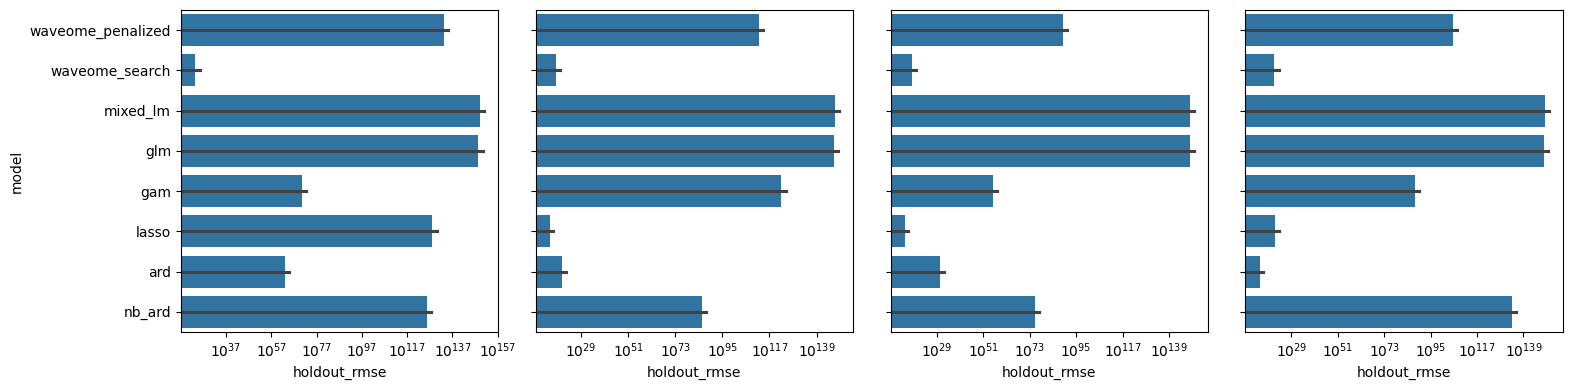

In [29]:
figs, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
for i in range(1, 5):
    sns.barplot(
        data=sim_results.query(f'output == "y{i}"').assign(holdout_rmse = lambda x: np.sqrt(x['holdout_mse'])),
        y="model",
        x="holdout_rmse",
        ax=axs[(i-1)],
        errorbar=('sd', 1)
    )
    axs[(i-1)].set_xscale('log')
plt.tight_layout()
plt.show()

### Holdout KL-Divergence Figures

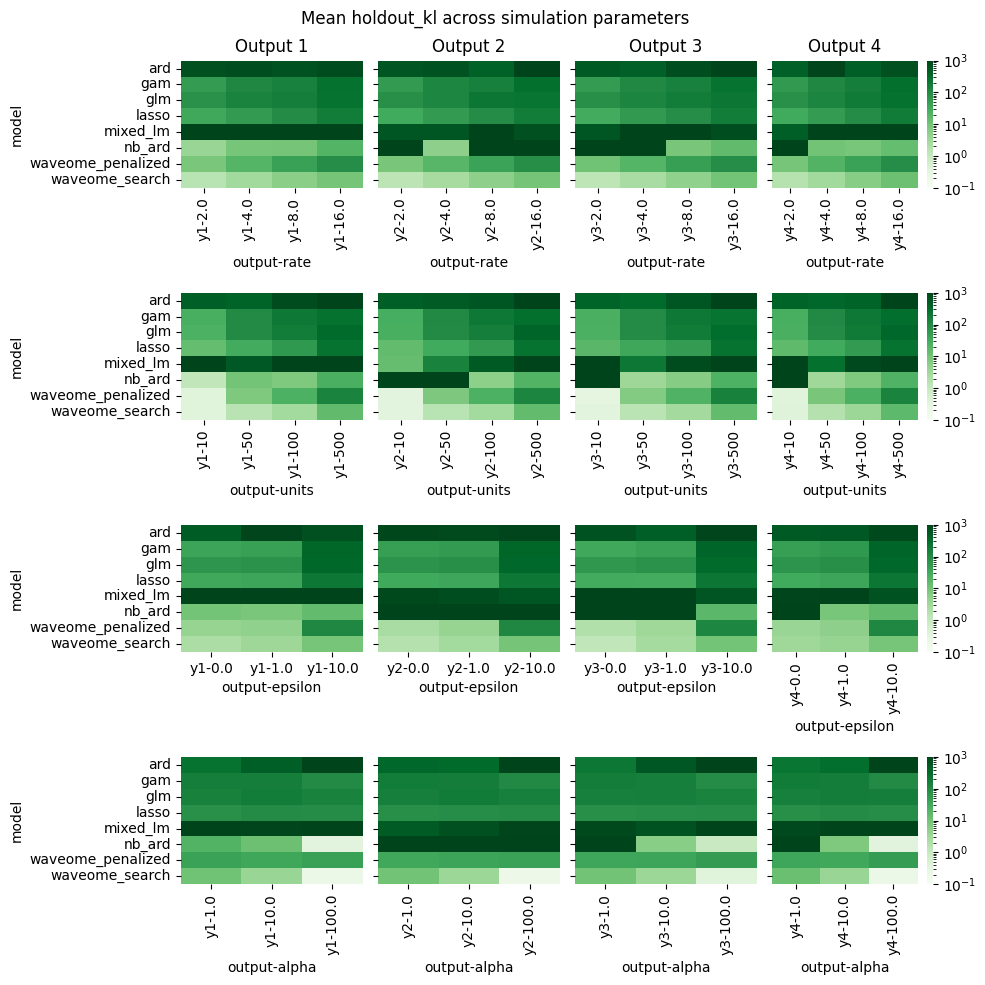

In [30]:
# Take a look at holdout KL values for a variety of simulation settings

# This can also be "holdout_mse" for mean squared error
metric = "holdout_kl"
agg_func = "mean"

figs, axs = plt.subplots(4, 4, sharey=True, figsize=(10, 10))

# Loop through simulation settings
for j, f in enumerate(["rate", "units", "epsilon", "alpha"]):

    # Prepare data by putting in the long format
    sim_heatmap_data = (
        sim_results#_clipped
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=[metric])
        .groupby(
            ["model", "output", f],
            as_index=False
        )
        [metric]
        .agg(agg_func)
        .pivot(
            index=["output", f],
            columns="model",
            values=metric,
        )
        .sort_values(["output", f])
    )

    # Now plot sub-heatmap for each simulation feature and output
    for i, o in enumerate(["y1", "y2", "y3", "y4"]):
        sns.heatmap(
            data=(
                sim_heatmap_data.query(f"output == '{o}'")
                .transpose()
            ),
            robust=True,
            vmin=0,
            vmax=100,
            ax=axs[j][i],
            cbar=False if o != "y4" else True,
            cmap="Greens",
            norm=LogNorm(vmin=0.1, vmax=1000)
        )
        
        # Do some labeling for clean up
        if o != "y1":
            axs[j][i].set_ylabel("")

        if f == "rate":
            axs[j][i].set_title(f"Output {o[1:]}")

plt.suptitle(f"{agg_func.capitalize()} {metric} across simulation parameters")
plt.tight_layout()

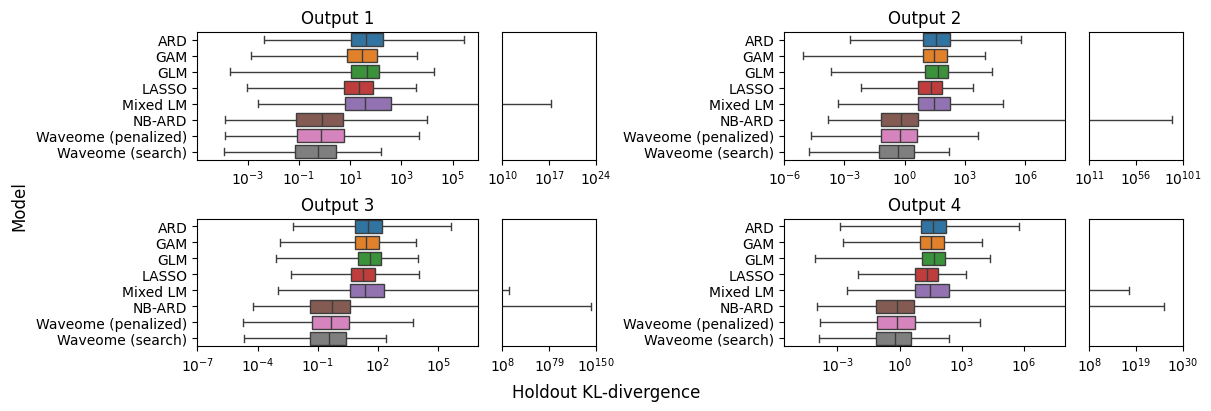

In [31]:
# Build boxplot figure for paper
fig = plt.figure(
    constrained_layout=True,
    figsize=(12, 4)
)
spec = fig.add_gridspec(
    nrows=2,
    ncols=4,
    width_ratios=[1.5, 0.5, 1.5, 0.5],
    height_ratios=[1, 1]
)

c1 = 0
c2 = 0
for o in sim_results.output.unique():
    ax_ = fig.add_subplot(spec[c1, c2])
    sns.boxplot(
        data=(
            sim_results
            .query(f"output == '{o}'")
            .assign(model = lambda x: x.model.astype("category").cat.rename_categories(
                {
                    "ard": "ARD",
                    "gam": "GAM",
                    "glm": "GLM",
                    "lasso": "LASSO",
                    "mixed_lm": "Mixed LM",
                    "nb_ard": "NB-ARD",
                    "waveome_penalized": "Waveome (penalized)",
                    "waveome_search": "Waveome (search)"
                }
            ))
        ),
        hue="model",
        y="model",
        x="holdout_kl",
        ax=ax_,
        log_scale=True,
        whis=(0, 100),
        palette="tab10",
        legend=False
    )

    if o == "y1":
        ax_.set_xlim(None, 1e6)
    elif o == "y2":
        ax_.set_xlim(1e-6, 1e8)
    elif o == "y3":
        ax_.set_xlim(1e-7, 1e7)
    elif o == "y4":
        ax_.set_xlim(None, 1e8)
    ax_.set_title(f"Output {o[1]}")
    ax_.set_ylabel("")
    ax_.set_xlabel("")

    c2+=1
    ax_ = fig.add_subplot(spec[c1, c2])

    # Now plot outliers
    sns.boxplot(
        data=(
            sim_results
            .query(f"output == '{o}'")
            .assign(model = lambda x: x.model.astype("category").cat.rename_categories(
                {
                    "ard": "ARD",
                    "gam": "GAM",
                    "glm": "GLM",
                    "lasso": "LASSO",
                    "mixed_lm": "Mixed LM",
                    "nb_ard": "NB-ARD",
                    "waveome_penalized": "Waveome (penalized)",
                    "waveome_search": "Waveome (search)"
                }
            ))
        ),
        hue="model",
        y="model",
        x="holdout_kl",
        ax=ax_,
        log_scale=True,
        whis=(0, 100),
        palette="tab10",
        legend=False
    )
    if o == "y1":
        ax_.set_xlim(1e10, 1e24)
    elif o == "y2":
        ax_.set_xlim(1e11, 1e101)
    elif o == "y3":
        ax_.set_xlim(1e8, 1e150)
    elif o == "y4":
        ax_.set_xlim(1e8, 1e30)
    ax_.set_yticklabels([])
    ax_.set_yticks([])
    ax_.set_ylabel("")
    ax_.set_xlabel("")
    c2 += 1

    if c2 == 4:
        c1 += 1
        c2 = 0

fig.supxlabel("Holdout KL-divergence")
fig.supylabel("Model")
fig.savefig(fname="../../figures/sim_kl_divergence.png", dpi=1000)
plt.show()

### Feature Selection Evaluation

In [32]:
# Correct features
correct_feats = {
    "y1": ["id", "time"],
    "y2": ["id", "id*time", "time"],
    "y3": ["id", "treat"],
    "y4": ["id", "treat", "id*time"]
}

all_feats = [
    "id", "time", "treat",
    "id*time", "id*treat",
    "time*treat"
]

sim_feats = sim_results.features.str.split(",").values

In [33]:
# Functions for feature evaluation metrics
def specificity(selected_feats, true_feats, all_feats):
    false_feats = [x for x in all_feats if x not in true_feats]
    unselected_feats = [x for x in all_feats if x not in selected_feats]
    # TN
    num = sum([x in false_feats for x in unselected_feats])
    # TN + FP
    denom = len(false_feats)
    return float(num) / float(denom)

def precision(selected_feats, true_feats):
    # TP
    # num = sum([x in true_feats for x in selected_feats])
    num = len(set(selected_feats) & set(true_feats))
    # TP + FP
    denom = len(selected_feats)
    return float(num) / float(denom)

# This is the same thing as sensitivity
def recall(selected_feats, true_feats):
    # TP
    num = len(set(selected_feats) & set(true_feats))
    # TP + FN
    denom = len(true_feats)
    return float(num) / float(denom)


# Not sure if we really want to show this metric because it assumes a particular tradeoff that might not be true
def f1_score(precision, recall):
    num = precision * recall
    denom = precision + recall
    if denom == 0:
        return 0
    return 2 * num / denom

# Test functions
# print(recall(selected_feats=["a"], true_feats=["a", "b"]))
print(f"selected_feats={sim_feats[0]},\ntrue_feats={correct_feats['y1']}")
print()
s_ = specificity(selected_feats=sim_feats[0], true_feats=correct_feats['y1'], all_feats=all_feats)
p_ = precision(selected_feats=sim_feats[0], true_feats=correct_feats['y1'])
r_ = recall(selected_feats=sim_feats[0], true_feats=correct_feats['y1'])
f_ = f1_score(precision=p_, recall=r_)
print(f"specificity = {s_}")
print(f"precision = {p_}")
print(f"recall = {r_}")
print(f"f1 score = {f_}")

def calc_feature_metrics(x, correct_feats, all_feats):
    sim_feats = x.features.split(",")
    gen_feats = correct_feats[x.output]
    x["specificity"] = specificity(selected_feats=sim_feats, true_feats=gen_feats, all_feats=all_feats)
    x["precision"] = precision(selected_feats=sim_feats, true_feats=gen_feats)
    x["recall"] = recall(selected_feats=sim_feats, true_feats=gen_feats)
    x["f1"] = f1_score(
        precision=precision(selected_feats=sim_feats, true_feats=gen_feats),
        recall=recall(selected_feats=sim_feats, true_feats=gen_feats)
    )
    return x

# Attach metrics to simulation results dataframe
sim_results = sim_results.apply(calc_feature_metrics, correct_feats=correct_feats, all_feats=all_feats, axis=1)

selected_feats=['id*time'],
true_feats=['id', 'time']

specificity = 0.75
precision = 0.0
recall = 0.0
f1 score = 0


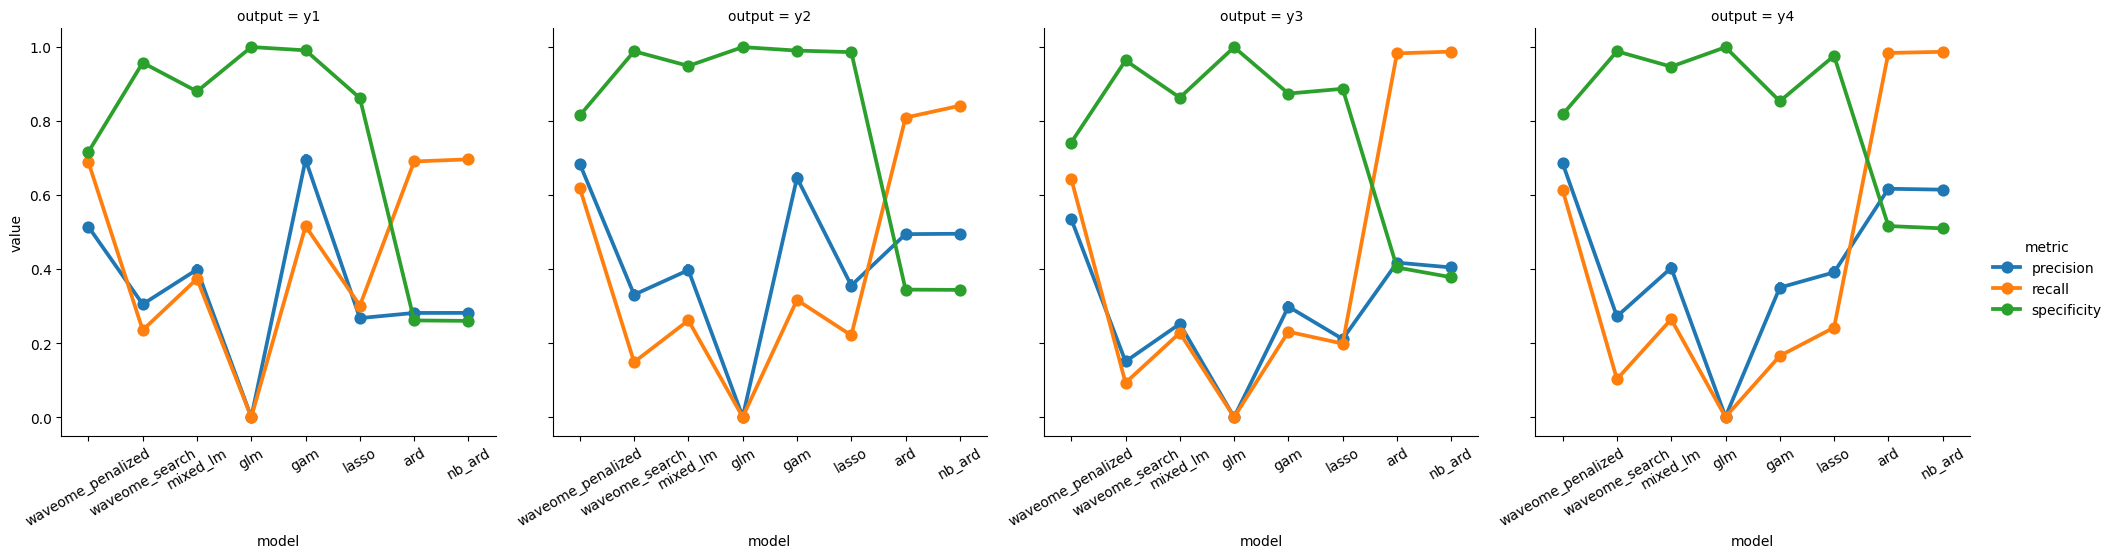

In [34]:
# Show plot
g = sns.catplot(
    data=pd.melt(
        frame=sim_results,
        id_vars=["model", "output"],
        value_vars=[
            "precision",
            "recall",
            "specificity",
            # "f1"
        ],
        var_name="metric",
        value_name="value"
    ),
    y="value",
    x="model",
    hue="metric",
    col="output",
    errorbar=("ci", 95),
    kind="point",
    sharex=False
)
g.set_xticklabels(rotation=30)
plt.show()

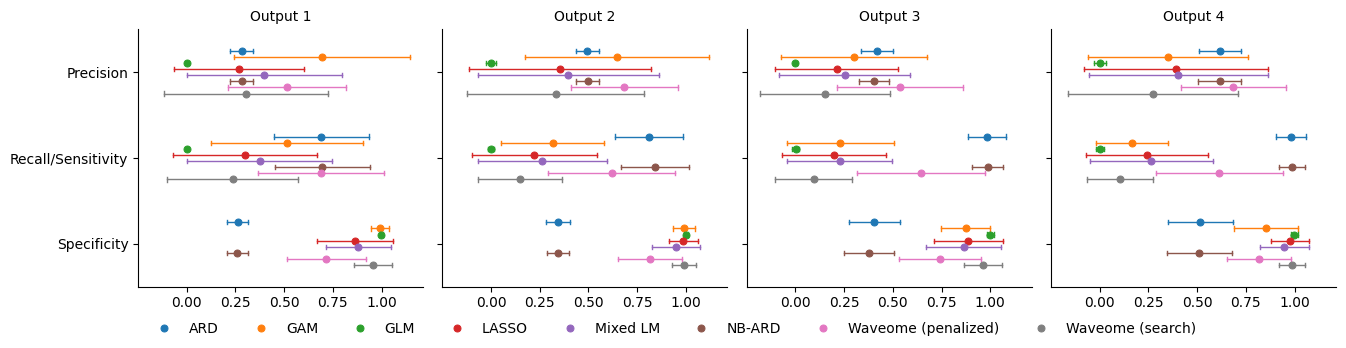

In [35]:
# Sensitivity/specificty plot for paper
g = sns.catplot(
    data=pd.melt(
        frame=(sim_results
            .assign(
                model = lambda x: x.model.astype("category").cat.rename_categories(
                    {
                        "ard": "ARD",
                        "gam": "GAM",
                        "glm": "GLM",
                        "lasso": "LASSO",
                        "mixed_lm": "Mixed LM",
                        "nb_ard": "NB-ARD",
                        "waveome_penalized": "Waveome (penalized)",
                        "waveome_search": "Waveome (search)"
                    }
                ),
                output = lambda x: x.output.str[1:]
            )
            .rename(
                columns={
                    "output": "Output",
                    "model": "Model",
                    "precision": "Precision",
                    "recall": "Recall/Sensitivity",
                    "specificity": "Specificity"
                }
            )
        ),
        id_vars=["Model", "Output"],
        value_vars=[
            "Precision",
            "Recall/Sensitivity",
            "Specificity",
            # "f1"
        ],
        var_name="metric",
        value_name="value"
    ),
    x="value",
    y="metric",
    hue="Model",
    col="Output",
    col_wrap=4,
    estimator="mean",
    errorbar=("sd", 1),
    kind="point",
    dodge=0.5,
    linestyle="none",
    palette="tab10",
    sharex=True,
    sharey=True,
    height=3.5,
    linewidth=1,
    capsize=0.05,
    markersize=5.0

)
sns.move_legend(g, loc="lower center", ncol=8, title=None)
g.set_titles(template="{col_var} {col_name}")
g.set_axis_labels(y_var="", x_var="")
g.savefig(fname="../../figures/sens_spes_sim.png", dpi=1000)
plt.show()

/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_95365/3423089678.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby(['model', 'output']).agg(


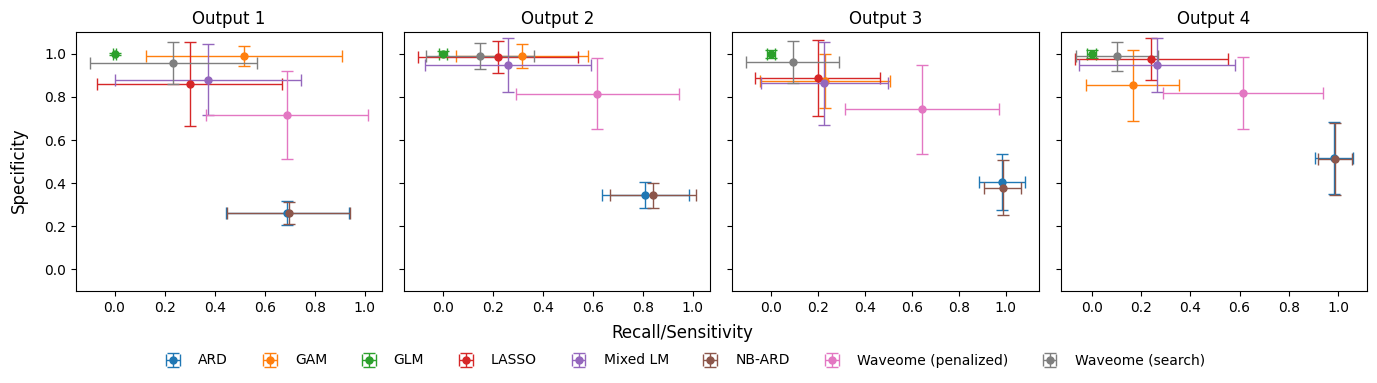

In [40]:
# Summarize feature selection
summary = (
    sim_results
    .assign(
        model = lambda x: x.model.astype("category").cat.rename_categories(
            {
                "ard": "ARD",
                "gam": "GAM",
                "glm": "GLM",
                "lasso": "LASSO",
                "mixed_lm": "Mixed LM",
                "nb_ard": "NB-ARD",
                "waveome_penalized": "Waveome (penalized)",
                "waveome_search": "Waveome (search)"
            }
        )
    ).groupby(['model', 'output']).agg(
        mean_x=('recall', 'mean'),
        std_x=('recall', 'std'),
        # mean_x=('precision', 'mean'),
        # std_x=('precision', 'std'),
        # std_x=('recall', lambda x: 1.96 * x.std(ddof=1) / (len(x) ** 0.5)),
        mean_y=('specificity', 'mean'),
        std_y=('specificity', 'std')
        # std_y=('specificity', lambda x: 1.96 * x.std(ddof=1) / (len(x) ** 0.5))
    ).reset_index()
)

fig, ax = plt.subplots(1, 4, figsize=(14, 3.5), sharey=True)

# Plot one point per group, with error bars in x and y
for _, row in summary.iterrows():
    o_index = row['output'][1]
    ax[(int(o_index)-1)].errorbar(
        row['mean_x'], row['mean_y'],
        xerr=row['std_x'], yerr=row['std_y'],
        fmt='o', capsize=4, label=row['model'],
        markersize=5, elinewidth=1
    )
    ax[(int(o_index)-1)].set_ylim(-0.1, 1.1)
    ax[(int(o_index)-1)].set_ylim(-0.1, 1.1)
    ax[(int(o_index)-1)].set_title(f"Output {o_index}")

# ax.legend(title='Model')
# fig.legend(title='Model', loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.05), fontsize=10)
fig.supxlabel('Recall/Sensitivity')
fig.supylabel('Specificity')
plt.tight_layout(rect=[0.01, -0.05, 1, 1])  # [left, bottom, right, top]
# Get handles and labels from the last axes (or any with all models)
handles, labels = ax[0].get_legend_handles_labels()

# Add a shared horizontal legend below all subplots
fig.legend(
    handles, labels,
    # title='Model',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),  # x=50%, y=just below the figure
    ncol=len(labels),             # one column per model
    fontsize=10,
    title_fontsize=11,
    frameon=False
)
plt.savefig(fname="../../figures/sens_spes_sim_cross.png", dpi=1000, bbox_inches='tight')
plt.show()


In [37]:
# # Summary table
# # pd.set_option('display.max_rows', 10000000)
# sim_results.groupby(["rate", "units", "epsilon", "alpha", "model", "output"], as_index=False)["holdout_kl"].mean().pivot(
#     index=["output", "rate", "units", "epsilon", "alpha"],
#     columns="model",
#     values="holdout_kl",
# ).sort_values("waveome_search").round(4).style.highlight_min(
#     color = 'lightgreen',  
#     axis = 1,
#     subset=["ard", "gam", "glm", "lasso", "mixed_lm", "nb_ard", "waveome_penalized", "waveome_search"]
# )